In [1]:
    from toolz.curried import partial, groupby, do, identity, last, flip, compose, map, filter, complement
    import abc, toolz.curried.operator, builtins, collections, copy, functools, importlib, inspect, types
    if __name__ == '__main__':
        from IPython import get_ipython;get_ipython() and get_ipython().events.register('post_execute', lambda: __import__('doctest').testmod(optionflags=8))
    
    __all__ = 'Composition', 'Juxt', 'IfThen', 'IfNot', 'λ', 'partial'

In [2]:
    class Null(BaseException): 
        """Null is a False exception.
    
    >>> assert not Null()
    
        """
        def __bool__(Null): return False
    Ø = Null

In [3]:
    class Juxtapose:
        """Juxtapose turns iterables into functions
    
        >>> Juxt(10)(10)
        10
        >>> Juxt({range, type})(10)
        {<class 'int'>, range(0, 10)}
        >>> Juxt([range, type])(10)
        [range(0, 10), <class 'int'>]
        >>> Juxt({'abc': range, identity: compose(str.upper, str)})(10)
        {'abc': range(0, 10), 10: '10'}
        >>> assert Juxt(range) is range
        """
        __slots__ = 'object',
        def __new__(Juxt, object):
            if callable(object): return object
            Juxt = super().__new__(Juxt)
            Juxt.__init__(object)
            Juxt.object = object
            return Juxt
            
        def __iter__(Juxt):
            if hasattr(Juxt.object, 'items'): yield from map(type(Juxt), Juxt.object.items())
            elif toolz.isiterable(Juxt.object) and not isinstance(Juxt.object, str): 
                yield from map(type(Juxt), Juxt.object)
            else: yield Juxt.object
                
        def __call__(Juxt, *args, **kwargs):
            func = next
            if not isinstance(Juxt.object, str) and toolz.isiterable(Juxt.object):
                func = type(Juxt.object)
            return func(type(Juxt)(object)(*args, **kwargs) if callable(object) else object for object in Juxt)
        
        def __bool__(Juxtapose): return bool(Juxtapose.object)
    Juxt = Juxtapose

In [4]:
    class Ordering:
        def __eq__(Ordering, object):
            if isinstance(Ordering, Compose) and isinstance(object, Compose):
                return Ordering.__getstate__() == Ordering.__getstate__()
            return False
        
        def __copy__(self, *memo, deep=False):
            object = type(self)()
            state = self.__getstate__()
            if deep: state = tuple(map(copy.deepcopy, state))
            object.__setstate__(state)
            return object
            
        __deepcopy__ = functools.partialmethod(__copy__, deep=True)

In [5]:
    _patched_operator = {}
    for key, op in vars(toolz.curried.operator).items():
        if key in {'attrgetter','itemgetter', 'methodcaller'}:
            _patched_operator[key] = partial(op)
        else:
            _patched_operator[key] = flip(op)

In [6]:
    class Attributes:
        def __getstate__(Attributes):
            return tuple(getattr(Attributes, slot) for slot in Attributes.__slots__)
                
        def __setstate__(Attributes, values):
            tuple(setattr(Attributes, slot, value) for slot, value in zip(Attributes.__slots__, values))
                
        __sources__ = collections.ChainMap(
            vars(toolz), vars(builtins), _patched_operator, {'fnmatch': flip(__import__('fnmatch').fnmatch), 'Path': __import__('pathlib').Path}
        )
        def __getitem__(Composition, object): 
            if isinstance(Composition, type): Composition = Composition()
            if object == slice(None): return Composition
            object = Juxt(object)
            if not isinstance(object, functools.partial): object = functools.partial(object)
            return copy.deepcopy(Composition).__getattr__(object)
        
        def __getattr__(Composition, object):
            if isinstance(Composition, type): Composition = Composition()
            first, funcs = map(bool, (Composition.first, Composition.funcs))
            if first and funcs: func = Composition.funcs[-1]
            else: func = Composition.funcs and Composition.funcs[-1] or Composition.first
            if isinstance(object, str) and not object.startswith('_'):
                if hasattr(func, object): object = getattr(func, object)
                elif object in Composition.__sources__:  object = Composition.__sources__.get(object)
                else:  
                    try: object = importlib.import_module(object)
                    except ModuleNotFoundError: raise AttributeError(object)
            elif isinstance(object, str): raise AttributeError
                
            object = Juxt(object)
            
            if isinstance(func, functools.partial):
                # First would exist if we get here
                Composition.funcs += object,
            else:
                if not Composition.funcs: Composition.first = object                        
                else: Composition.funcs[-1] = object
                    
            return Composition


In [7]:
    class Ops(Attributes):

        def _inc(self, func, object): return self[:].__getattr__(partial(func(Juxt(object))))
        def _op(self, func, object):  return self[:][partial(func(Juxt(object)))]
        def excepts(self, *exceptions, copy=True):
            return setattr(self, '_excepts', exceptions) or (copy and __import__('copy').deepcopy or identity)(Composition()[self])
        
    for attr, func in [
        ['mul', map], ['truediv', filter], ['matmul', groupby], ['floordiv', toolz.curried.reduce],
        ['lshift', do], ['add', partial], ['sub', partial], ['rshift', partial]]: 
        setattr(Ops, F"__{attr}__", functools.partialmethod(Ops._op, func))
        setattr(Ops, F"__r{attr}__", functools.partialmethod(Ops._op, func))
        hasattr(Ops, func.__name__) or setattr(Ops, func.__name__, functools.partialmethod(Ops._op, func))
        setattr(Ops, F"__i{attr}__", functools.partialmethod(Ops._inc, func))
    setattr(Ops, F"__xor__", Ops.excepts)
    setattr(Ops, F"__rxor__", Ops.excepts)
    setattr(Ops, F"__ixor__", functools.partialmethod(Ops.excepts, copy=False))
        

In [8]:
    class Compose(toolz.functoolz.Compose):
        __slots__ = toolz.functoolz.Compose.__slots__ + ('_excepts', '_prior')
        def __new__(Compose, *, excepts=None, prior=None):
            Compose = super().__new__(Compose)
            Compose.__init__(excepts=excepts, prior=prior)
            return Compose
        
        def __init__(Compose, *args, excepts=None, prior=None):
            super().__init__(list(reversed(args or (None,))))
            Compose.funcs = list(Compose.funcs)
            Compose._excepts = excepts
            Compose._prior = prior
        
        def __call__(Compose, *args, **kwargs):
            func = last(Compose.funcs) if Compose.funcs else Compose.first      
            if func is None:
                return args[0] if args else None
            if isinstance(func, functools.partial): 
                if Compose._excepts:
                    try: return super().__call__(*args, **kwargs)
                    except Compose._excepts as Exception: return Null(Exception)
                return super().__call__(*args, **kwargs)
            if Compose.funcs: Compose.funcs[-1] = functools.partial(func, *args, **kwargs)
            else: Compose.first = functools.partial(func or identity, *args, **kwargs)
            return Compose
        
        def __iter__(Compose):
            if Compose._prior:
                yield Compose._prior
            yield Compose.first or identity
            yield from Compose.funcs
        

In [9]:
    class Conditions:
        def __pow__(self, object):
            """Symbol for a condtional composition.
            """

            if isinstance(object, tuple) and all(isinstance(x, type) for x in object):
                object = flip(isinstance)(object)
            if isinstance(self, type): return Conditional(prior=object)
            return Conditional(prior=object)[self[:]]
        def __and__(self, object):  
            """Symbol for an IfThen composition.


            """           
            self = IfThen(prior=self[:])
            return object and self[object] or self
        def __or__(self, object):  
            """Symbol for an IfNot composition.
            """           

            self = IfNot(prior=self[:])
            return object and self[object] or self

In [10]:
    class CompositionBase(Conditions, Ops, abc.ABCMeta): ...

    class Composition(Ops, Compose, Conditions, Ordering, metaclass=CompositionBase):
        def __repr__(Composition):
            return str(type(Composition).__name__) + "("+",".join(str(inspect.unwrap(getattr(func, 'func', func)) if not (getattr(func, 'args', None) or getattr(func, 'keywords', None)) else func) for func in filter(bool, Composition))+")"
        
        def _repr_html_(Compose, *body):
            import html, IPython
            shell = IPython.get_ipython()
            for i, func in enumerate(Compose):
                if isinstance(func, functools.partial) and not (func.args or func.keywords):
                    func = func.func
                body += F"""<details><summary><b>{i+1}.<b/>&nbsp;<code>{html.escape(repr(func))}</code></summary>{shell.inspector._get_info(func)['text/html']}</details>""",
            return ''.join(body)
            
    λ = Composition

In [11]:
    class Conditional(Composition):
        """Conditional evaluates the composition if prior is True.
    
    >>> c = Conditional(prior=bool)[range]
    >>> c
    Conditional(<class 'bool'>,<class 'range'>)
    >>> c(0), c(10)
    (False, range(0, 10))

    >>> p = (λ**bool)[identity]
    >>> p(0), p(10)
    (False, 10)

    """
        def __call__(Composition, *args, **kwargs):
            object = Composition._prior(*args, **kwargs)
            return super().__call__(*args, **kwargs) if object else object

    class IfThen(Composition):
        """IfThen evaluates a continues evaluation of the prior value is True, the return is piped to the composition.
        
    >>> i = IfThen(prior=bool)[range]
    >>> i
    IfThen(<class 'bool'>,<class 'range'>)
    >>> i(0), i(10)
    (False, range(0, True))

    >>> p = λ + bool & identity
    >>> p(0), p(10)
    (False, True)

    """
        def __call__(Composition, *args, **kwargs):
            object = Composition._prior(*args, **kwargs)
            return super().__call__(object) if object else object
    class IfNot(Composition):
        """IfNot evaluates a continues evaluation of the prior value is False.
        
    >>> i = IfNot(prior=bool)[range]
    >>> i
    IfNot(<class 'bool'>,<class 'range'>)
    >>> i(0), i(10)
    (range(0, 0), True)

    >>> p = (λ**bool+range)  | identity
    >>> p(0), p(11)
    (0, range(0, 11))
    """

        def __call__(Composition, *args, **kwargs):
            object = Composition._prior(*args, **kwargs)
            return object if object else super().__call__(*args, **kwargs)
        

In [12]:
    def ipython_display(Composition): # pragma: no cover
        import IPython
        IPython.display.display(Composition(*Composition._args, **Composition._kwargs))
        IPython.display.display(IPython.display.HTML(Composition._repr_html_()))

    def watch(*args, **kwargs):
        def call(callable):
            if isinstance(callable, type): callable = callable()
            callable._args, callable._kwargs = args, kwargs
            setattr(callable, '_ipython_display_', types.MethodType(ipython_display, callable))
            return callable
        return call
    
    def Λ(*args, **kwargs): return watch(*args, **kwargs)(Composition[:])

In [24]:
    __test__ = {}
    __test__['main']=\
    """>>> λ.range()
    λ(<class 'range'>)

    >>> assert λ.range() == λ[range]

    >>> λ.range().sum()(4)
    6

    >>> f = λ.str.upper()
    >>> f('foo')
    'FOO'
    >>> f - len
    λ(<...str...>,<...len>)

    >>> λ.str.upper().range()
    λ(<...upper...of...str...>,<...range...>)


    >>> g = (λ**(int,)+range)|(λ**(str,)+str.upper)
    >>> g._prior, g                                   #doctest: +ELLIPSIS
    (Conditional(...range...), IfNot(Conditional(...range...),Conditional(...upper...str...)))

    >>> shell = __import__('IPython').get_ipython()

    > shell.display_formatter.format(f)
    ({'text/plain'...'text/html': '<details><summary>...</summary><h1>Docstring</h1>...</details>'}, {})

    >>> g = ((λ**(int,)+range))
    >>> g(10), g('abc')
    (range(0, 10), False)

    >>> h = copy.copy(g)
    >>> assert h == g and h is not g
    >>> assert h.__getstate__() == g.__getstate__()

    >>> m = (λ.range()**(str,))^TypeError
    >>> m
    Composition(Conditional(<...>,Composition(<...'range'>)))

    >>> m('10')
    Ø(TypeError("'str' object cannot be interpreted as an integer",),)
    >>> assert not m('10')


    >>> m = λ[range] * (lambda x: x*10) + list
    >>> m
    λ(<class 'range'>,<class 'map'>,<class 'list'>)
    >>> m(10)
    [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    >>> f = λ[range] * (lambda x: x/2) / complement(lambda x: x%2) + list
    >>> f
    λ(<class 'range'>,<class 'map'>,<class 'filter'>,<class 'list'>)
    >>> f(10)
    [0.0, 2.0, 4.0]
    
    >>> f[type]
    Composition(<class 'range'>,<class 'map'>,<class 'filter'>,<class 'list'>,<class 'type'>)
    >>> f
    λ(<class 'range'>,<class 'map'>,<class 'filter'>,<class 'list'>)
    
    >>> f += type; f
    Composition(<class 'range'>,<class 'map'>,<class 'filter'>,<class 'list'>,<class 'type'>)

    
    >>> g = λ[range] @ (lambda x:x//4)
    >>> g
    λ(<class 'range'>,<...groupby...>)
    >>> g(10)
    {0: [0, 1, 2, 3], 1: [4, 5, 6, 7], 2: [8, 9]}

    >>> r = λ.range() // (lambda a, b: a+b)
    >>> r
    λ(<...reduce>)
    >>> r(10)
    45
    
    >>> λ.identity().builtins.range(10)._repr_html_()
    '<details><summary><b>1.<b/>...</details>'
    
    >>> assert λ.builtins.range() == λ.range() == λ[range]
    
    >>> λ.nah
    Traceback (most recent call last):
    ...
    AttributeError: nah
    
    
    >>> λ.range().builtins.type()
    Composition(<class 'range'>,<class 'type'>)
    
    >>> λ()(10)
    10
    >>> λ.sub(2)(8), λ.truediv(2)(8)
    (6, 4.0)
    
    >>> λ.Path()()
    PosixPath('.')
    
    >>> (λ*λ.fnmatch('foo*')>>list)(('foobar', 'baz'))
    [True, False]

    """.replace(*'λ Composition'.split()).replace(*'Ø Null'.split())
    
    try:
        __test__['ipy'] = """
    >>> import IPython
    >>> f = λ[range] * (lambda x: x/2) / complement(lambda x: x%2) + list
    
    
    >>> Λ(10)[range]
    Composition(<class 'range'>)

    >>> with IPython.utils.capture.capture_output() as out: IPython.display.display(watch(10)(λ))
    >>> with IPython.utils.capture.capture_output() as out: IPython.display.display(watch(10)(f))
    >>> out.outputs[0].data
    """
        if isinstance(__import__('IPython').get_ipython(), __import__('ipykernel.zmqshell').zmqshell.ZMQInteractiveShell): # pragma: no cover
            __test__['ipy'] += """{'text/plain': '[0.0, 2.0, 4.0]'}"""
        else:
            __test__['ipy'] += """{'text/plain': "Composition(<class 'range'>,<class 'map'>,<class 'filter'>,<class 'list'>)"}"""

    except ModuleNotFoundError: # pragma: no cover
        ...

[NbConvertApp] Converting notebook poser.ipynb to python
[NbConvertApp] Writing 14975 bytes to poser.py
Fixing /Users/tonyfast/poser/poser.py
]0;IPython: tonyfast/poserTestResults(failed=0, attempted=69)
Name       Stmts   Miss Branch BrPart  Cover
--------------------------------------------
poser.py     196      0     69      0   100%


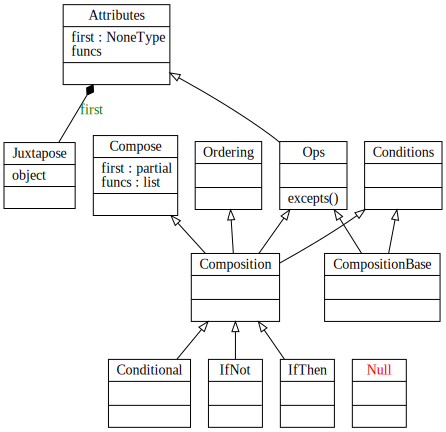

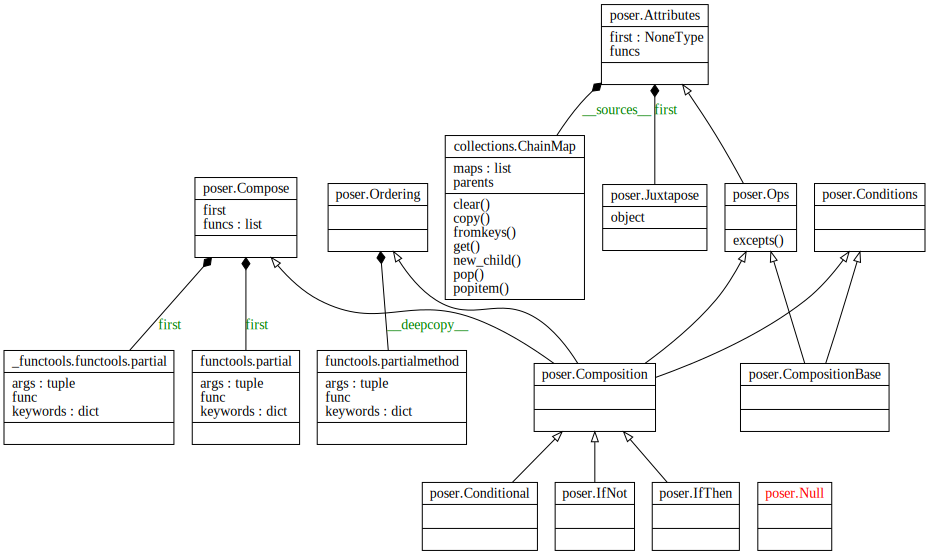

In [25]:
    if __name__ == '__main__': 
        if 'covtest' in __import__('sys').argv:
            print(__import__('doctest').testmod(optionflags=8))
        else:
            import IPython; complement, copy, compose
            !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True poser.ipynb
            with IPython.utils.capture.capture_output():
                !black poser.py
            !isort poser.py
            !pyflakes poser.py
            !ipython -m coverage -- run poser.py covtest
            !coverage report
            !coverage html
            with IPython.utils.capture.capture_output():
                !pyreverse poser -osvg -pposer
            IPython.display.display(IPython.display.SVG('classes_poser.svg'))
            with IPython.utils.capture.capture_output():
                !pyreverse poser -osvg -pposer -my -s1
            IPython.display.display(IPython.display.SVG('classes_poser.svg'))

